Loading /Users/sarabadih/Desktop/mne-python/f096049-Hb_Moments.snirf


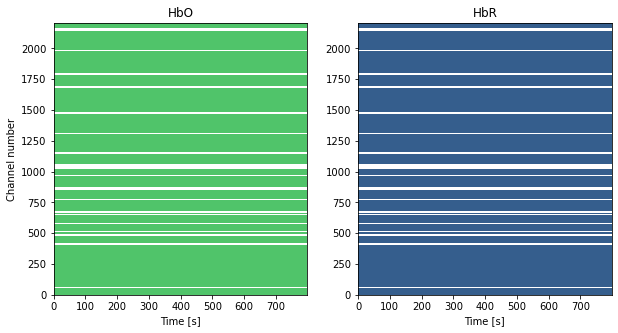

In [1]:
# %% Imports
import numpy as np
import matplotlib.pyplot as plt
from mne.io.snirf import read_raw_snirf

# %% Reading the file
#path_to_snirf = "2021_08-Finger_Tapping-Hb.snirf"
#path_to_snirf = "1745f1d-Moments.snirf"
path_to_snirf = "f096049-Hb_Moments.snirf" #Patient 1 Run 1 data
snirf = read_raw_snirf(path_to_snirf)

# %% Obtaining general information 
# you can query snirf.info for measurement data/time
# information about the channels (their names and locations) can also be accessed in snirf.info as follows:
channel_names = [x['ch_name'] for x in snirf.info['chs']]
is_hbo = np.array([1 if channel_name.endswith(
   'HbO') else 0 for channel_name in channel_names], dtype=bool)
channel_locations_3d = [x['loc'][:3] for x in snirf.info['chs']] 

# %% Obtaining NIRS data
a = snirf.get_data()

# %% Plotting 
_, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].pcolor(snirf.times, np.arange(np.sum(is_hbo)),
            a[is_hbo, :], shading='nearest')
ax[0].set_title('HbO')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Channel number')
ax[1].pcolor(snirf.times, np.arange(np.sum(~is_hbo)),
            a[~is_hbo, :], shading='nearest')
ax[1].set_title('HbR')
ax[1].set_xlabel('Time [s]')
plt.show() 

In [21]:
#Read In additional Annotations

#print(snirf.annotations)
print(str(snirf.info))
assert len(channel_names)==len(channel_locations_3d) #4412 channels

<Info | 9 non-empty values
 bads: []
 ch_names: S01_D01d1 HbO, S00_D01d5 HbO, S01_D01d1 HbR, S00_D01d5 HbR, ...
 chs: 4412 FNIRS_PROCESSED
 custom_ref_applied: False
 dig: 4415 items (3 Cardinal, 4412 EEG)
 highpass: 0.0 Hz
 lowpass: 3.5 Hz
 meas_date: 2021-06-24 00:07:19 UTC
 nchan: 4412
 projs: []
 sfreq: 7.1 Hz
 subject_info: 1 item (dict)
>
4412


Text(0, 0.5, 'Left Channel')

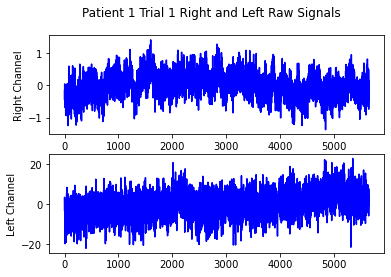

In [69]:
#Patient 1 Run 1, Obtaining 2 HbO Channels (Left and Right of Brain)

#Right Channel HbO Signal
assert(is_hbo[8])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
assert(snirf.get_data().shape)==(4412,5653) #4412 channels by 5653 signal points per channel
snirf_d=snirf.get_data()
d=snirf_d[8,:] #Extract the 8th channel signal
fig, axs = plt.subplots(2)
fig.suptitle('Patient 1 Trial 1 Right and Left Raw Signals')
axs[0].plot(d,color="blue",label="Right")
axs[0].set_ylabel("Right Channel")

#Left Channel HbO Signal
assert(is_hbo[4080])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
f=snirf_d[4080,:] #Extract the 8th channel signal
axs[1].plot(f,color="blue",label="Left")
axs[1].set_ylabel("Left Channel")

In [71]:
len(f)

5653

In [77]:
snirf.times

array([0.000000e+00, 1.413000e-01, 2.826000e-01, ..., 7.983450e+02,
       7.984863e+02, 7.986276e+02])

In [79]:
movingaverage(snirf.times, 20)

array([  1.34235,   1.48365,   1.62495, ..., 797.00265, 797.14395,
       797.28525])

Text(0, 0.5, 'Left Channel')

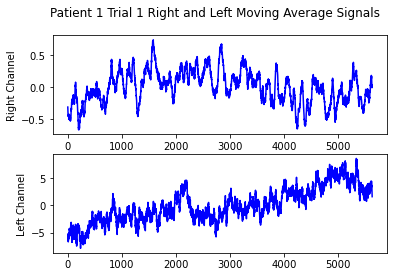

In [60]:
#Apply Moving Average to the data
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    return np.convolve(np.squeeze(values), weights, 'valid')

fig, axs = plt.subplots(2)
fig.suptitle('Patient 1 Trial 1 Right and Left Moving Average Signals')
axs[0].plot(movingaverage(d, 20),color="blue",label="Right")
axs[0].set_ylabel("Right Channel")

#Left Channel HbO Signal
assert(is_hbo[4080])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
f=snirf_d[4080,:] #Extract the 8th channel signal
axs[1].plot(movingaverage(f, 20),color="blue",label="Left")
axs[1].set_ylabel("Left Channel")

In [76]:
len(movingaverage(f, 10))

5644

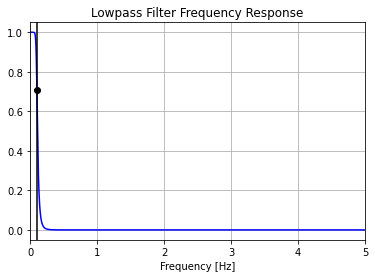

In [52]:
#Low Pass Filter
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Setting standard filter requirements.
order = 6
fs = 10   #This is the sampling rate I derived from the cutoff frequency they used(0.1=Fs/2)(Sampling Frequency has to be greater than 0.2)   
cutoff = 0.1  

b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response.
w, h = freqz(b, a, worN=8000)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


[-2.66493295e-10 -3.43064505e-09 -2.21560749e-08 ... -1.09204169e-01
 -1.11771550e-01 -1.14179055e-01]


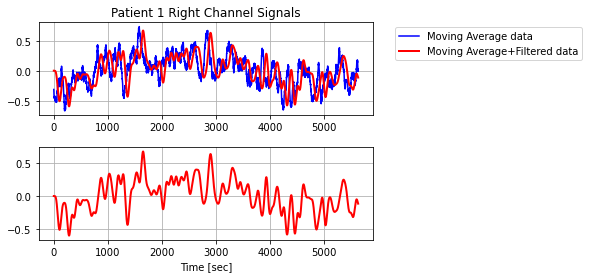

In [64]:
# # Creating the data for filteration
T = 800         # value taken in seconds
t = np.linspace(0, T, 5653, endpoint=False)

# Filtering and plotting
p1_rf = butter_lowpass_filter(movingaverage(d,20), cutoff, fs, order) #patient 1 right filtered signal
print(p1_rf)
plt.subplot(2, 1, 1)
plt.title("Patient 1 Right Channel Signals")
plt.plot(movingaverage(d,20), 'b-', label='Moving Average data')
plt.plot(p1_rf, 'r-', linewidth=2, label='Moving Average+Filtered data')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.subplot(2, 1, 2)
plt.plot(p1_rf, 'r-', linewidth=2, label='Moving Average+Filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.subplots_adjust(hspace=0.35)

Text(0.5, 0, 'Time [sec]')

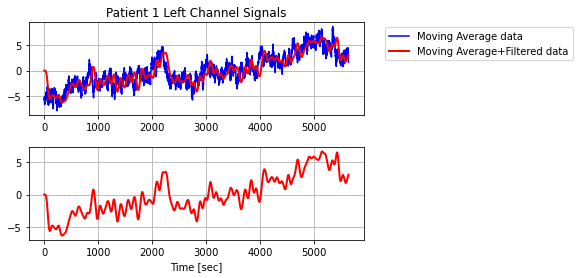

In [65]:
# Filtering and plotting
p1_lf = butter_lowpass_filter(movingaverage(f,20), cutoff, fs, order) #patient 1 left filtered signal
plt.subplot(2, 1, 1)
plt.plot(movingaverage(f,20), 'b-', label='Moving Average data')
plt.plot(p1_lf, 'r-', linewidth=2,label='Moving Average+Filtered data')
plt.title("Patient 1 Left Channel Signals")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.subplot(2, 1, 2)
plt.plot(p1_lf, 'r-', linewidth=2, label='Moving Average+Filtered data')
plt.grid()
plt.subplots_adjust(hspace=0.35)
plt.xlabel('Time [sec]')

In [68]:
#Logistic Regression Model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#What would be our y labels in this case
df = pd.read_excel (r'/Users/sarabadih/Desktop/f096049_task_events.xlsx', sheet_name='f096049_task_events')
print (df)

#Extract the timestamp and block_type columns
time_stamps=df["timestamp"] #582 timestamps
block_type=df["block_type"]


#Boolean Array
    #Make all the left taps 1 and right taps 0
    for i in enumerate time_stamps:
        if i =="left"
        
        elif i =="right"

    
#We have 583 points ranging from 0 to 769

      timestamp             event    duration experiment_type  block  \
0      0.000000  start_experiment  789.392488  finger_tapping    NaN   
1      0.089842        start_rest   20.018517  finger_tapping    NaN   
2     20.108440       start_block   17.714409  finger_tapping    1.0   
3     20.156964         start_ITI    0.513069  finger_tapping    1.0   
4     20.670118       start_trial    0.806002  finger_tapping    1.0   
..          ...               ...         ...             ...    ...   
577  766.298867       start_trial    0.791355  finger_tapping   20.0   
578  767.139773         start_ITI    0.752528  finger_tapping   20.0   
579  767.892369       start_trial    0.802379  finger_tapping   20.0   
580  768.739782         start_ITI    0.567454  finger_tapping   20.0   
581  769.374845        start_rest   20.017540  finger_tapping    NaN   

    block_type  trial trial_type  
0          NaN    NaN        NaN  
1          NaN    NaN        NaN  
2        right    NaN        N

In [ ]:
print